In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Custom training and batch prediction

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/sdk-custom-image-classification-batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fcustom%2Fsdk-custom-image-classification-batch.ipynb">
      <img width="32px" src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/custom/sdk-custom-image-classification-batch.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/sdk-custom-image-classification-batch.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

## Overview


This tutorial demonstrates how to use the Vertex AI SDK for Python to train and deploy a custom image classification model for batch prediction.

Learn more about [Custom training](https://cloud.google.com/vertex-ai/docs/training/custom-training) and [Vertex AI Batch Prediction](https://cloud.google.com/vertex-ai/docs/tabular-data/classification-regression/get-batch-predictions).

### Objective

In this tutorial, you learn to use Vertex AI Training to create a custom trained model and use Vertex AI Batch Prediction to do a batch prediction on the trained model.


Create a custom-trained model from a Python script in a Docker container using the Vertex AI SDK for Python, and then do a prediction on the deployed model by sending data. Alternatively, you can create custom-trained models using `gcloud` command-line tool, or online using the Cloud Console.

This tutorial uses the following Google Cloud ML services:

- Vertex AI Training
- Vertex AI Batch Prediction
- Vertex AI Model resource


The steps performed include:

- Create a Vertex AI custom job for training a TensorFlow model.
- Upload the trained model artifacts as a model resource.
- Make a batch prediction.

### Dataset

The dataset used for this tutorial is the [cifar10 dataset](https://www.tensorflow.org/datasets/catalog/cifar10) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use is built into TensorFlow. The trained model predicts which type of class an image is from ten classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

### Costs

This tutorial uses billable components of Google Cloud (GCP):

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Get started

### Install Vertex AI SDK for Python and other required packages


In [1]:
! pip3 install --upgrade google-cloud-aiplatform \
                        google-cloud-storage \
                        pillow  \
                        numpy    

  Using cached google_cloud_storage-3.0.0-py2.py3-none-any.whl.metadata (12 kB)


### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.

In [1]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

Authenticate your environment on Google Colab.


In [1]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK for Python

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [1]:
PROJECT_ID = "projet-ia-448520"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

#### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [2]:
BUCKET_URI = f"gs://cours3bucket"#-{PROJECT_ID}-unique"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [4]:
#! gsutil mb -l $LOCATION -p $PROJECT_ID $BUCKET_URI

#### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [3]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)

### Import libraries and define constants

In [4]:
import os

### Set pre-built containers

Vertex AI provides pre-built containers to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [5]:
TRAIN_VERSION = "tf-cpu.2-9"
DEPLOY_VERSION = "tf2-cpu.2-9"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

# Tutorial

Now you are ready to start creating your own custom-trained model with CIFAR10.

## Train a model

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.

### Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they will be:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--steps=" + STEPS`: The number of steps (batches) per epoch.
  - `"--distribute=" + TRAIN_STRATEGY"` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

In [6]:
JOB_NAME = "custom_job_unique"
MODEL_DIR = "{}/{}".format(BUCKET_URI, JOB_NAME)


TRAIN_STRATEGY = "single"

EPOCHS = 20
STEPS = 100

CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]

#### Training script

In the next cell, you will write the contents of the training script, `task.py`. In summary:

- Get the directory where to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is set by the training service.
- Loads CIFAR10 dataset from TF Datasets (tfds).
- Builds a model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs` and `args.steps`
- Saves the trained model (`save(MODEL_DIR)`) to the specified model directory.

In [9]:
%%writefile task.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling CIFAR10 data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='cifar10',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(MODEL_DIR)

Overwriting task.py


### Train the model

Define your custom training job on Vertex AI.

Use the `CustomTrainingJob` class to define the job, which takes the following parameters:

- `display_name`: The user-defined name of this training pipeline.
- `script_path`: The local path to the training script.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model — either a prebuilt container or a custom container.

Use the `run` function to start training, which takes the following parameters:

- `args`: The command line arguments to be passed to the Python script.
- `replica_count`: The number of worker replicas.
- `model_display_name`: The display name of the `Model` if the script produces a managed `Model`.
- `machine_type`: The type of machine to use for training. ex: "n1-standard-8"
- `accelerator_type`: The hardware accelerator type. ex: "NVIDIA_TESLA_T4"
- `accelerator_count`: The number of accelerators to attach to a worker replica. ex: 1

The `run` function creates a training pipeline that trains and creates a `Model` object. After the training pipeline completes, the `run` function returns the `Model` object.

In [10]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==1.3.0"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

MODEL_DISPLAY_NAME = "model_unique"

# Start the training

model = job.run(
    model_display_name=MODEL_DISPLAY_NAME,
    args=CMDARGS,
    replica_count=1,
)

Training script copied to:
gs://cours3bucket/aiplatform-2025-02-10-16:33:13.349-aiplatform_custom_trainer_script-0.1.tar.gz.
Training Output directory:
gs://cours3bucket/aiplatform-custom-training-2025-02-10-16:33:13.876 
View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1988489834217340928?project=837843744498
View backing custom job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/9031599032669044736?project=837843744498
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/1988489834217340928 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/1988489834217340928 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/1988489834217340928 current state:
3
CustomTrainingJob projects/837843744498/locations/us-central1/trainingPipelines/1988489834217340928 current state:
3
CustomTrainingJob projects/837843744

## Make a batch prediction request

Send a batch prediction request to your deployed model.

### Get test data

Download images from the CIFAR dataset and preprocess them.

#### Download the test images

Download the provided set of images from the CIFAR dataset:

In [26]:
# Download the images
! gsutil -m cp -r gs://cloud-samples-data/ai-platform-unified/cifar_test_images .

Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_8.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_5.jpg...
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_0_6.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_1.jpg...
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_4_10.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/image_2_9.jpg...
/ [0/10 files][    0.0 B/  8.7 KiB]   0% Done                                   
Copying gs://cloud-samples-data/ai-platform-unified/cifar_test_images/im

In [7]:
import numpy as np
from PIL import Image

# Load image data
IMAGE_DIRECTORY = "cifar_test_images"

image_files = [file for file in os.listdir(IMAGE_DIRECTORY) if file.endswith(".jpg")]

# Decode JPEG images into numpy arrays
image_data = [
    np.asarray(Image.open(os.path.join(IMAGE_DIRECTORY, file))) for file in image_files
]

# Scale and convert to expected format
x_test = [(image / 255.0).astype(np.float32).tolist() for image in image_data]

# Extract labels from image name
y_test = [int(file.split("_")[1]) for file in image_files]

#### Prepare data for batch prediction
Before you can run the data through batch prediction, you need to save the data into one of a few possible formats.

For this tutorial, use JSONL as it's compatible with the 3-dimensional list that each image is currently represented in. To do this:

1. In a file, write each instance as JSON on its own line.
2. Upload this file to Cloud Storage.

For more details on batch prediction input formats: https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions#batch_request_input

In [8]:
import json

BATCH_PREDICTION_INSTANCES_FILE = "batch_prediction_instances.jsonl"

BATCH_PREDICTION_GCS_SOURCE = (
    BUCKET_URI + "/batch_prediction_instances/" + BATCH_PREDICTION_INSTANCES_FILE
)

# Write instances at JSONL
with open(BATCH_PREDICTION_INSTANCES_FILE, "w") as f:
    for x in x_test:
        f.write(json.dumps(x) + "\n")

# Upload to Cloud Storage bucket
! gsutil cp $BATCH_PREDICTION_INSTANCES_FILE $BATCH_PREDICTION_GCS_SOURCE

print("Uploaded instances to: ", BATCH_PREDICTION_GCS_SOURCE)

Uploaded instances to:  gs://cours3bucket/batch_prediction_instances/batch_prediction_instances.jsonl


Copying file://batch_prediction_instances.jsonl [Content-Type=application/octet-stream]...
/ [0 files][    0.0 B/617.6 KiB]                                                
/ [1 files][617.6 KiB/617.6 KiB]                                                
-

Operation completed over 1 objects/617.6 KiB.                                    


### Send the prediction request

To make a batch prediction request, call the model object's `batch_predict` method with the following parameters: 
- `instances_format`: The format of the batch prediction request file: "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" or "file-list"
- `prediction_format`: The format of the batch prediction response file: "jsonl", "csv", "bigquery", "tf-record", "tf-record-gzip" or "file-list"
- `job_display_name`: The human readable name for the prediction job.
 - `gcs_source`: A list of one or more Cloud Storage paths to your batch prediction requests.
- `gcs_destination_prefix`: The Cloud Storage path that the service will write the predictions to.
- `model_parameters`: Additional filtering parameters for serving prediction results.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `starting_replica_count`: The number of compute instances to initially provision.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

### Compute instance scaling

You can specify a single instance (or node) to process your batch prediction request. This tutorial uses a single node, so the variables `MIN_NODES` and `MAX_NODES` are both set to `1`.

If you want to use multiple nodes to process your batch prediction request, set `MAX_NODES` to the maximum number of nodes you want to use. Vertex AI autoscales the number of nodes used to serve your predictions, up to the maximum number you set. Refer to the [pricing page](https://cloud.google.com/vertex-ai/pricing#prediction-prices) to understand the costs of autoscaling with multiple nodes.


In [9]:
MIN_NODES = 1
MAX_NODES = 1

# The name of the job
BATCH_PREDICTION_JOB_NAME = "cifar10_batch_prediction_unique"

# Folder in the bucket to write results to
DESTINATION_FOLDER = "batch_prediction_results"

# The Cloud Storage bucket to upload results to
BATCH_PREDICTION_GCS_DEST_PREFIX = BUCKET_URI + "/" + DESTINATION_FOLDER

# Make SDK batch_predict method call
batch_prediction_job = model.batch_predict(
    instances_format="jsonl",
    predictions_format="jsonl",
    job_display_name=BATCH_PREDICTION_JOB_NAME,
    gcs_source=BATCH_PREDICTION_GCS_SOURCE,
    gcs_destination_prefix=BATCH_PREDICTION_GCS_DEST_PREFIX,
    model_parameters=None,
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    machine_type="n1-standard-4",
    sync=True,
    spot=False
)

NameError: name 'model' is not defined

### Retrieve batch prediction results
When the batch prediction is done processing, you can finally view the predictions stored at the Cloud Storage path you set as output. The predictions will be in a JSONL format, which you indicated when you created the batch prediction job. The predictions are located in a subdirectory starting with the name prediction. Within that directory, there is a file named prediction.results-xxxx-of-xxxx.

Let's display the contents. You will get a row for each prediction. The row is the softmax probability distribution for the corresponding CIFAR10 classes.

In [18]:
RESULTS_DIRECTORY = "prediction_results"
RESULTS_DIRECTORY_FULL = RESULTS_DIRECTORY + "/" + DESTINATION_FOLDER

# Create missing directories
os.makedirs(RESULTS_DIRECTORY, exist_ok=True)

# Get the Cloud Storage paths for each result
! gsutil -m cp -r $BATCH_PREDICTION_GCS_DEST_PREFIX $RESULTS_DIRECTORY

# Get most recently modified directory
latest_directory = max(
    (
        os.path.join(RESULTS_DIRECTORY_FULL, d)
        for d in os.listdir(RESULTS_DIRECTORY_FULL)
    ),
    key=os.path.getmtime,
)

# Get downloaded results in directory
results_files = []
for dirpath, subdirs, files in os.walk(latest_directory):
    for file in files:
        if file.startswith("prediction.results"):
            results_files.append(os.path.join(dirpath, file))

# Consolidate all the results into a list
results = []
for results_file in results_files:
    # Download each result
    with open(results_file, "r") as file:
        results.extend([json.loads(line) for line in file.readlines()])

Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_10T07_58_01_210Z/prediction.results-00000-of-00001...
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_10T07_58_01_210Z/prediction.errors_stats-00000-of-00001...
/ [0/4 files][    0.0 B/  1.2 MiB]   0% Done                                    
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_10T04_59_07_506Z/prediction.errors_stats-00000-of-00001...
/ [0/4 files][    0.0 B/  1.2 MiB]   0% Done                                    
Copying gs://cours3bucket/batch_prediction_results/prediction-model_unique-2025_02_10T04_59_07_506Z/prediction.results-00000-of-00001...
/ [0/4 files][    0.0 B/  1.2 MiB]   0% Done                                    
/ [0/4 files][    0.0 B/  1.2 MiB]   0% Done                                    
/ [1/4 files][    0.0 B/  1.2 MiB]   0% Done                                    
/ [2/4 files][    0.0 B/  1.2 MiB]   

### Evaluate results

You can then run a quick evaluation on the prediction results:

1. `np.argmax`: Convert each list of confidence levels to a label
2. Compare the predicted labels to the actual labels
3. Calculate `accuracy` as `correct/total`

To improve the accuracy, try training for a higher number of epochs.

In [19]:
y_predicted = [np.argmax(result["prediction"]) for result in results]

correct = sum(y_predicted == np.array(y_test))
accuracy = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {accuracy}, Accuracy = {correct/accuracy}"
)

Correct predictions = 2, Total predictions = 10, Accuracy = 0.2


# Online prediction

## Make an online prediction request

Send an online prediction request to your deployed model.
### Get test data

Download images from the CIFAR dataset and preprocess them.

#### Download the test images

Download the provided set of images from the CIFAR dataset:

### Deploy the model

Before you use your model to make predictions, you need to deploy it to an `Endpoint`. You can do this by calling the `deploy` function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.


The function takes the following parameters:

- `deployed_model_display_name`: A human readable name for the deployed model.
- `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then use `model_id` to specify as **{ "0": percent, model_id: percent, ... }**, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `starting_replica_count`: The number of compute instances to initially provision.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

### Traffic split

The `traffic_split` parameter is specified as a Python dictionary. You can deploy more than one instance of your model to an endpoint, and then set the percentage of traffic that goes to each instance.

You can use a traffic split to introduce a new model gradually into production. For example, if you had one existing model in production with 100% of the traffic, you could deploy a new model to the same endpoint, direct 10% of traffic to it, and reduce the original model's traffic to 90%. This allows you to monitor the new model's performance while minimizing the distruption to the majority of users.

### Compute instance scaling

You can specify a single instance (or node) to serve your online prediction requests. This tutorial uses a single node, so the variables `MIN_NODES` and `MAX_NODES` are both set to `1`.

If you want to use multiple nodes to serve your online prediction requests, set `MAX_NODES` to the maximum number of nodes you want to use. Vertex AI autoscales the number of nodes used to serve your predictions, up to the maximum number you set. Refer to the [pricing page](https://cloud.google.com/vertex-ai/pricing#prediction-prices) to understand the costs of autoscaling with multiple nodes.

### Endpoint

The method will block until the model is deployed and eventually return an `Endpoint` object. If this is the first time a model is deployed to the endpoint, it may take a few additional minutes to complete provisioning of resources.

#### Preprocess the images
Before you can run the data through the endpoint, you need to preprocess it to match the format that your custom model defined in `task.py` expects.

`x_test`:
Normalize (rescale) the pixel data by dividing each pixel by 255. This replaces each single byte integer pixel with a 32-bit floating point number between 0 and 1.

`y_test`:
You can extract the labels from the image filenames. Each image's filename format is "image_{LABEL}_{IMAGE_NUMBER}.jpg"

In [11]:
DEPLOYED_NAME = "cifar10_deployed_unique"

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1


endpoint = model.deploy(
    deployed_model_display_name=DEPLOYED_NAME,
    traffic_split=TRAFFIC_SPLIT,
    min_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
)

Creating Endpoint
Create Endpoint backing LRO: projects/837843744498/locations/us-central1/endpoints/3914675910766231552/operations/6216935508505788416
Endpoint created. Resource name: projects/837843744498/locations/us-central1/endpoints/3914675910766231552
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/837843744498/locations/us-central1/endpoints/3914675910766231552')
Deploying model to Endpoint : projects/837843744498/locations/us-central1/endpoints/3914675910766231552
Using default machine_type: n1-standard-2
Deploy Endpoint model backing LRO: projects/837843744498/locations/us-central1/endpoints/3914675910766231552/operations/1765971701780185088
Endpoint model deployed. Resource name: projects/837843744498/locations/us-central1/endpoints/3914675910766231552


#### Preprocess the downloaded test images
Before you can run the data through the endpoint, you need to preprocess it to match the format that your custom model defined in `task.py` expects.

`x_test`:
Normalize (rescale) the pixel data by dividing each pixel by 255. This replaces each single byte integer pixel with a 32-bit floating point number between 0 and 1.

`y_test`:
You can extract the labels from the image filenames. Each image's filename format is "image_{LABEL}_{IMAGE_NUMBER}.jpg"

In [12]:
import os
import numpy as np
from PIL import Image

# Load image data
IMAGE_DIRECTORY = "cifar_test_images"

image_files = [file for file in os.listdir(IMAGE_DIRECTORY) if file.endswith(".jpg")]

# Decode JPEG images into numpy arrays
image_data = [
    np.asarray(Image.open(os.path.join(IMAGE_DIRECTORY, file))) for file in image_files
]

# Scale and convert to expected format
x_test = [(image / 255.0).astype(np.float32).tolist() for image in image_data]

# Extract labels from image name
y_test = [int(file.split("_")[1]) for file in image_files]

### Send the prediction request

Now that you have test images, you can use them to send a prediction request. Use the `Endpoint` object's `predict` function, which takes the following parameters:

- `instances`: A list of image instances. According to your custom model, each image instance should be a 3-dimensional matrix of floats. This was prepared in the previous step.

The `predict` function returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.

You can then run a quick evaluation on the prediction results:
1. `np.argmax`: Convert each list of confidence levels to a label
2. Compare the predicted labels to the actual labels
3. Calculate `accuracy` as `correct/total`

In [26]:
predictions = endpoint.predict(instances=x_test)
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test))
total_predictions = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {total_predictions}, Accuracy = {correct/total_predictions}"
)

Correct predictions = 2, Total predictions = 10, Accuracy = 0.2


#  Appel à l'endpoint deployé

In [9]:
ENDPOINT_ID="3914675910766231552"
PROJECT_ID="837843744498"

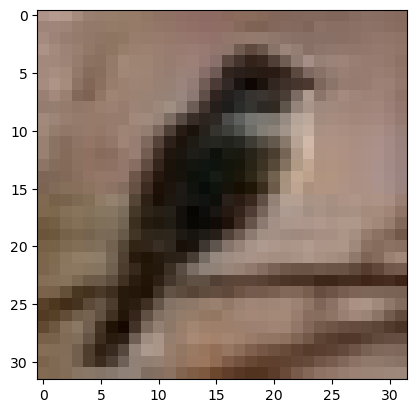

In [40]:
import matplotlib.pyplot as plt
plt.imshow(x_test[3])
plt.show()

In [41]:
from google.cloud import aiplatform
# Initialiser le client Vertex AI
aiplatform.init(project=PROJECT_ID)

# Obtenir l'endpoint
endpoint = aiplatform.Endpoint(ENDPOINT_ID)

# Faire la prédiction
response = endpoint.predict(instances=x_test)
y_predicted = np.argmax(response.predictions, axis=1)
correct = sum(y_predicted == np.array(y_test))
total_predictions = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {total_predictions}, Accuracy = {correct/total_predictions}"
)

Correct predictions = 2, Total predictions = 10, Accuracy = 0.2


# Load testing with locust

In [ ]:
# !pip install locust

In [ ]:
from locust import HttpUser, task, between
from google.cloud import aiplatform
from google.oauth2 import service_account
import json
import time

class VertexAIUser(HttpUser):
    # Temps d'attente entre les requêtes
    wait_time = between(1, 3)
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Configuration Vertex AI
        self.project_id = "837843744498"
        self.location = "us-central1"
        self.endpoint_id = "3914675910766231552"
        
        # Construction de l'URL de l'endpoint
        self.predict_url = f"/v1/projects/{self.project_id}/locations/{self.location}/endpoints/{self.endpoint_id}:predict"
        
        # Initialisation du client Vertex AI pour obtenir le token
        aiplatform.init(project=self.project_id, location=self.location)
        
        # Obtention du token d'authentification
        credentials = service_account.Credentials.from_service_account_file(
            "chemin/vers/votre/service-account.json",
            scopes=["https://www.googleapis.com/auth/cloud-platform"]
        )
        self.token = credentials.token
        
    def on_start(self):
        """Méthode appelée au démarrage de chaque utilisateur simulé"""
        # Configuration des headers pour l'authentification
        self.client.headers = {
            "Authorization": f"Bearer {self.token}",
            "Content-Type": "application/json"
        }

    @task
    def predict(self):
        """Tâche principale : appel à l'endpoint de prédiction"""
        payload = {
            "instances": [
                {
                    "feature1": 1.0,
                    "feature2": "value2"
                    # Ajoutez vos features selon votre modèle
                }
            ]
        }
        
        with self.client.post(
            self.predict_url,
            json=payload,
            catch_response=True
        ) as response:
            if response.status_code == 200:
                response.success()
            else:
                response.failure(f"Échec de la requête: {response.status_code}")
                
        # Ajout d'une métrique personnalisée pour le temps de latence
        self.environment.events.request.fire(
            request_type="POST",
            name="predict",
            response_time=response.elapsed.total_seconds() * 1000,
            response_length=len(response.content),
            exception=None,
            context={}
        )

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Training Job
- Model
- Cloud Storage Bucket

In [ ]:
# Warning: Setting this to true will delete everything in your bucket
delete_bucket = False

# Delete the training job
job.delete()

# Delete the model
model.delete()

if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI